In [ ]:
# !pip install ray

In [ ]:
# !pip install ray[rllib]

In [3]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
import time
import json
import pickle
import collections

import gym
from gym.spaces import Box
import ray
from ray import tune
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
class Action(object):
    """
    shipping to warehouses and changes in production level
    """

    def __init__(self, no_of_warehouses):
        self.production_level = 0  # b(0,t)
        self.shippings = np.repeat(0, no_of_warehouses)  # W(j,t)


class State(object):
    """
    defining the state of the environment
    """

    def __init__(self, no_of_warehouses, demand_history, eps, t=0):
        self.no_of_warehouses = no_of_warehouses  # W
        self.demand_history = demand_history
        self.factory_stock = 0  # l(0,t)
        self.warehouse_stock = np.repeat(0, no_of_warehouses)  # l(j,t)
        self.eps = eps
        self.t = t

    def array_state(self):
        return np.concatenate(([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]))

    def stock_only(self):
        return np.concatenate(([self.factory_stock], self.warehouse_stock))


In [5]:
class Environment(object):
    """
    defining the reward distribution system
    and the next state based on the appropriate action and
    current state.
    """

    def __init__(self, eps=40, W=4, max_demand=5, r_var=2, c=35, p=98):
        """
            Initializing the initial conditions of the system.
        """
        self.eps = eps  # Epochs (transitions)
        self.no_of_warehouses = W
        self.d_max = max_demand  # maximum demand at warehouse w -> d(j, t)
        self.d_var = r_var  # maximum random variation in units in d(j,t) for different warehouses
        self.unit_cost = c  # c_0 -> production cost
        self.unit_price = p  # p->product price for retailers

        ''' storage capacity at the factory, storage capacity at each warehouse, rupees per unit
            first index because of factory warehouse followed by distribution warehouses'''
        self.storage_capacities = np.fromfunction(lambda j: 10 * (j + 1), (self.no_of_warehouses + 1,), dtype=int)

        ''' storage capacity at the factory, storage capacity at each warehouse, rupees per unit
            first index because of factory warehouse followed by distribution warehouses'''
        self.storage_costs = np.fromfunction(lambda j: 2 * (j + 1), (self.no_of_warehouses + 1,),
                                             dtype=int)

        # transportation costs for each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5 * (j + 1), (self.no_of_warehouses,),
                                                   dtype=int)
        self.penalty_unit_cost = self.unit_price

        self.reset()

    def reset(self, demand_history_len=4):
        """
        :param demand_history_len: defines number of past records to be tracked
        """
        self.t = 0
        self.demand_history = collections.deque(maxlen=demand_history_len)

        for _ in range(demand_history_len):
            self.demand_history.append(np.zeros(self.no_of_warehouses))

    def demand(self, t, j):
        """
        :param t: time at which demand is needed
        :param j: warehouse for which demand is needed
        :return: returns demand at time t for warehouse j
        """
        return np.round(
            self.d_max / 2 + self.d_max / 2 * np.sin(2 * np.pi * (t + 2 * j) / self.eps * 2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        """
        :return: returns initial state
        """
        return State(no_of_warehouses=self.no_of_warehouses, demand_history=list(self.demand_history), eps=self.eps)

    def step(self, state, action):
        """
        :param state: state instance
        :param action: action instance
        :return: next_state,rewards,completed episodes or not
        """
        demands = np.fromfunction(lambda j: self.demand(self.t, j + 1), (self.no_of_warehouses,), dtype=int)

        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot(self.storage_costs,
                                    np.maximum(state.stock_only(), np.zeros(self.no_of_warehouses + 1)))

        transportation_cost = np.dot(self.transporation_costs, action.shippings)
        penalty_cost = -1 * self.penalty_unit_cost * (
                np.sum(np.minimum(state.warehouse_stock, np.zeros(self.no_of_warehouses))) + min(
            state.factory_stock, 0))

        rewards = total_revenue - production_cost - total_storage_cost - penalty_cost - transportation_cost

        # Calculating next state
        next_state = State(no_of_warehouses=self.no_of_warehouses, demand_history=list(self.demand_history),
                           eps=self.eps,
                           t=self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings),
                                       self.storage_capacities[0])

        for i in range(self.no_of_warehouses):
            next_state.warehouse_stock[i] = min(
                state.warehouse_stock[i] + action.shippings[i] - demands[i],
                self.storage_capacities[i + 1])

        self.t += 1
        self.demand_history.append(demands)
        return next_state, rewards, self.t == self.eps - 1

In [7]:
tf = try_import_tf()

In [8]:
class SimpleChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.chain.no_of_warehouses + 1,),
                                dtype=np.float32)
        self.observation_space = Box(-10000, 10000,
                                     shape=(len(self.chain.initial_state().array_state()),),
                                     dtype=np.float32)

    def reset(self):
        self.chain = Environment()
        self.state = self.chain.initial_state()
        return self.state.array_state()

    def step(self, action):
        action_obj = Action(self.chain.no_of_warehouses)
        action_obj.production_level = action[0]
        action_obj.shippings = action[1:]
        self.state, reward, term_sig = self.chain.step(self.state, action_obj)
        return self.state.array_state(), reward, term_sig, {}


In [9]:
ray.shutdown()
ray.init()

2020-11-05 18:16:24,133	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


{'metrics_export_port': 35050,
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-11-05_18-16-23_585106_370/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2020-11-05_18-16-23_585106_370/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2020-11-05_18-16-23_585106_370',
 'webui_url': '127.0.0.1:8265'}

In [10]:
def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512]
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000
    
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleChain)
    for i in range(300):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

In [11]:
train_ddpg()

2020-11-05 18:16:26,547	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-11-05 18:16:26,548	INFO trainer.py:618 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-11-05 18:16:28,989	WARNING util.py:39 -- Install gputil for GPU system monitoring.


Streaming output truncated to the last 5000 lines.
date: 2020-11-05_19-52-20
done: false
episode_len_mean: 25.0
episode_reward_max: 7855.318004757166
episode_reward_mean: 4114.451913265446
episode_reward_min: -884.1606440991163
episodes_this_iter: 40
episodes_total: 8060
experiment_id: 1863e8e860bc48cd871e9d86434ecc84
hostname: fae47dddf38a
info:
  last_target_update_ts: 201498
  learner:
    default_policy:
      max_q: 3945.188720703125
      mean_q: 1579.9464111328125
      min_q: -1959.6827392578125
      model: {}
  num_steps_sampled: 201500
  num_steps_trained: 51200256
  num_target_updates: 33334
iterations_since_restore: 201
node_ip: 172.28.0.2
num_healthy_workers: 0
off_policy_estimator: {}
perf:
  cpu_util_percent: 56.4875
  ram_util_percent: 15.9
pid: 370
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_action_processing_ms: 0.09384878515905867
  mean_env_wait_ms: 0.25736872099868896
  mean_inference_ms: 2.038485096606735
  mean_raw_obs

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv("/root/ray_results/DDPG_SimpleChain_2020-11-05_18-16-26wbllyek3/progress.csv")

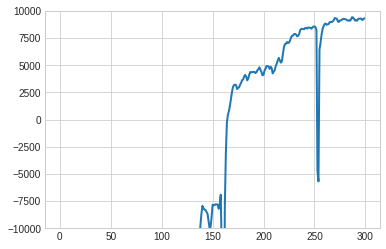

In [30]:
plt.ylim(-10000, 10000)
plt.plot(np.asarray(df['episode_reward_mean']))